In [1]:
#default_exp neighbors

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

- weighted NN based on (possibly batch) grad descent of feature weights
- find optimizer engine
- find fast KNN for query time
- Define metric specific sampling function (based on distance)) (possibly optimize func hyperparams during training, like $\alpha$ for $P_{sample} = Dist^{-\alpha}$ and others)
- Define cost function (possibly a product of entropy/variance divided by the KL div from percentiles dist and flat dirichlet (hypercube))
- Study cvxpy
- study metric learn


In [47]:
import os
from functools import partial
import numpy as np

from scipy import sparse
from scipy.optimize import minimize

from scikit_density.utils import cos_sim_query, sample_from_dist_array, sparse_mul_row, make_bimodal_regression,make_distplot

from scikit_density.metrics import kde_entropy, quantile, bimodal_variance, marginal_variance

## Training data

In [6]:
X_train, y_train, X_test, y_test = make_bimodal_regression(10000, random_state = 42, bimodal_inbalance = 5)

# Weighted KNN density estimator cvxpy

In [510]:
from time import time
def train_func(x):
    # draw batch from x
    #X_train, y_train, 
    n_samples = 40
    batch_size = X_train.shape[0]//5
    tic = time()
    n_neighbors = max(2, int(x[-1]))
    weights = x[:-1]
    idx = np.random.choice([*range(X_train.shape[0])], size = batch_size, replace = False)
    X_batch,y_batch = X_train[idx], y_train[idx]
    # transform search space and query vector through weights
    X_batch = sparse_mul_row(X_batch, weights)
    X_ = sparse_mul_row(X_train, weights)
    # make query of idx and wieghts
    idx, sim  = cos_sim_query(X_batch, X_, n_neighbors = n_neighbors)
    # draw samples from y
    sampled_idxs = sample_from_dist_array(arr = idx, size = n_samples, weights = sim)[:,:,-1]        
    samples = np.take(y_train, indices = sampled_idxs, axis = 0)
    # calculate variance
    loss = bimodal_var(samples).mean()
    #loss = -kde_entropy(quantile(y_batch,samples))[0]
    toc = time()
    print(f'iteration took {round(toc-tic,2)}s | loss: {loss}')    
    return loss

In [511]:
x0 = np.concatenate([np.ones(X_train.shape[1]), 8*np.ones(1)])
f = train_func

In [512]:
params = minimize(fun = f, x0 = x0,method = 'CG',options = {'maxiter':1000},)

iteration took 0.6s | loss: 9921.617022167675
iteration took 0.56s | loss: 9613.360734629226
iteration took 0.59s | loss: 9745.231325271689
iteration took 0.56s | loss: 9876.43035496605
iteration took 0.59s | loss: 9058.224739814375
iteration took 0.54s | loss: 9184.728424656654
iteration took 0.57s | loss: 9907.755288934912
iteration took 0.57s | loss: 9440.936946589085
iteration took 0.55s | loss: 9394.337932207507
iteration took 0.54s | loss: 8335.31292503648
iteration took 0.57s | loss: 9276.387525419424
iteration took 0.59s | loss: 9753.651839272803
iteration took 0.56s | loss: 9772.860516843968
iteration took 0.58s | loss: 9952.971544487384
iteration took 0.58s | loss: 9556.869822576982
iteration took 0.61s | loss: 9624.651710543767
iteration took 0.6s | loss: 9110.515350661068
iteration took 0.58s | loss: 9578.007501907416
iteration took 0.6s | loss: 10389.985280641575
iteration took 0.6s | loss: 9699.046453260462
iteration took 0.58s | loss: 10564.476141254583
iteration took 0.

iteration took 0.59s | loss: 9294.215572515372
iteration took 0.59s | loss: 9099.872840554306
iteration took 0.58s | loss: 9679.810952478556
iteration took 0.59s | loss: 9750.12747586039
iteration took 0.57s | loss: 8559.857837961821
iteration took 0.59s | loss: 9834.478077913396
iteration took 0.58s | loss: 8713.972023040835
iteration took 0.57s | loss: 10198.404448440757
iteration took 0.59s | loss: 9098.367348035395
iteration took 0.58s | loss: 9451.775032284115
iteration took 0.6s | loss: 8786.359136187148
iteration took 0.61s | loss: 8858.38188860499
iteration took 0.59s | loss: 8769.37174735146
iteration took 0.59s | loss: 9830.168455008086
iteration took 0.59s | loss: 8657.91589149326
iteration took 0.6s | loss: 10089.177831701569
iteration took 0.58s | loss: 9647.292493938228
iteration took 0.59s | loss: 8906.872905532802
iteration took 0.6s | loss: 8855.845440516898
iteration took 0.57s | loss: 10030.631538889693
iteration took 0.58s | loss: 9289.842881894676
iteration took 0.

iteration took 0.58s | loss: 9924.467730182289
iteration took 0.58s | loss: 9191.52639482932
iteration took 0.59s | loss: 10240.769399356393
iteration took 0.59s | loss: 9818.181302978433
iteration took 0.57s | loss: 10186.81778597961
iteration took 0.56s | loss: 10190.60324170128
iteration took 0.59s | loss: 8529.298640698527
iteration took 0.6s | loss: 10468.476333990322
iteration took 0.6s | loss: 9144.558099323662
iteration took 0.61s | loss: 9617.810104174154
iteration took 0.59s | loss: 9691.38301041594
iteration took 0.61s | loss: 9556.575524463275
iteration took 0.6s | loss: 10369.867707034857
iteration took 0.59s | loss: 8941.087425091
iteration took 0.57s | loss: 9937.983799854197
iteration took 0.56s | loss: 9540.662970685242
iteration took 0.61s | loss: 9713.010517258599
iteration took 0.6s | loss: 10021.581783575288
iteration took 0.6s | loss: 10441.709789836645
iteration took 0.56s | loss: 9313.31845474154
iteration took 0.61s | loss: 10551.800897533638
iteration took 0.6

In [513]:
params

     fun: 9251.928191777628
     jac: array([-4.12768373e+10,  1.87392297e+09, -2.08654901e+10, -1.67833870e+10,
        1.80450749e+10, -2.25005729e+10, -3.58411814e+10, -4.84502218e+09,
       -1.80818066e+10,  2.14982734e+10,  1.20240321e+10,  1.55736186e+10,
       -5.72650687e+10, -4.41084262e+10, -6.67344815e+10, -1.98314663e+10])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 461
     nit: 1
    njev: 25
  status: 2
 success: False
       x: array([1.00000249, 1.00000143, 1.00000037, 1.00000698, 1.00000596,
       1.00000011, 1.00000389, 1.00000426, 1.00001282, 1.00000522,
       1.00000136, 1.0000012 , 0.99999975, 1.00000295, 1.0000024 ,
       8.00000656])

# Weighted KNN DensityEstimator PyTorch

In [163]:
import pytorch_lightning as pl

from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn

from torch.autograd import Variable as V

def update_tensor(tensor, new_values):    
    try: 
        tensor =  tensor.data.fill_(1)*torch.Tensor(new_values)
    except: print(tensor.shape, new_values.shape); raise
    return tensor

In [189]:
class WeightedKNNTorch(pl.LightningModule):
    @property
    def weighted_query_space(self,):
        return sparse_mul_row(self.raw_query_space,self.weights.clone().detach().numpy()).astype('double')
    
    def __init__(self, X, y, n_neighbors, n_samples, layers = [], batch_size = 256):
        super().__init__()
        self.weights = torch.ones(X.shape[1], requires_grad = True)
        self.weights = nn.Parameter(self.weights, requires_grad=True)
        self.raw_query_space = sparse.csr_matrix(X)#X should be a sparse matrix
        self.y_ = y
        self.n_neighbors = n_neighbors
        self.n_samples = n_samples
        self.samples_tensor = torch.zeros(batch_size, n_samples, y.shape[-1], requires_grad = True)
        
    def _cos_sim_query(self,query_vector,query_space, n_neighbors):
        idx,sim = cos_sim_query(query_vector,query_space,n_neighbors)
        #drops the closest match which is the similarity of the row with itself
        #maybe n_neighbors > 1 deals with it
        #idx, sim = idx[:,1:], sim[:,1:]
        return idx,sim
    
    def _sample_values(self, idx, sim, n_samples):
        sampled_idxs = sample_from_dist_array(arr = idx, size = n_samples, weights = sim)[:,:,-1]        
        samples = np.take(self.y_, indices = sampled_idxs, axis = 0)
        return update_tensor(self.samples_tensor, samples)
        
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = sparse_mul_row(
            x.numpy(),
            self.weights.clone().detach().numpy()
        ).astype('double')
        idx, sim  = self._cos_sim_query(x,self.weighted_query_space, self.n_neighbors)
        samples = self._sample_values(idx,sim,self.n_samples)
        update_tensor(self.samples_tensor, samples)
        return self.samples_tensor

    def training_step(self, batch, batch_idx):
        if batch_idx == 0:
            self.loss_tensor = torch.ones(1).data.fill_(1000)
            self.loss_tensor.requires_grad = True
        # training_step defined the train loop. It is independent of forward
        X, y = batch
        samples = self.forward(X)        
        loss_tensor = self.loss_tensor
        #minimize uncertainty
        if batch_idx%2 == 0:
            loss = np.array([bimodal_variance(samples.clone().detach()).mean()])
            update_tensor(loss_tensor,loss)
            #loss = -kde_entropy(quantile(y.numpy(),samples))            
        else:
            #maximize entropy
            loss = np.array([bimodal_variance(samples.clone().detach()).mean()])
            update_tensor(loss_tensor,loss)
            #loss = -kde_entropy(quantile(y.numpy(),samples))        
        self.log('train_loss', loss_tensor)        
        
        return loss_tensor

    def configure_optimizers(self):        
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    

In [190]:

model = WeightedKNNTorch(X_train,y_train,50,200)

In [191]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size = 256) # create your dataloader

In [192]:
trainer = pl.Trainer(max_epochs=10)

trainer.fit(model, my_dataloader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name | Type | Params
------------------------------
------------------------------
15        Trainable params
0         Non-trainable params
15        Total params


torch.Size([256, 200, 2]) (64, 200, 2)



RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 0

In [357]:
i += 45
sample = model.forward(torch.Tensor(X_test[i]))
true_value = y_test[i]

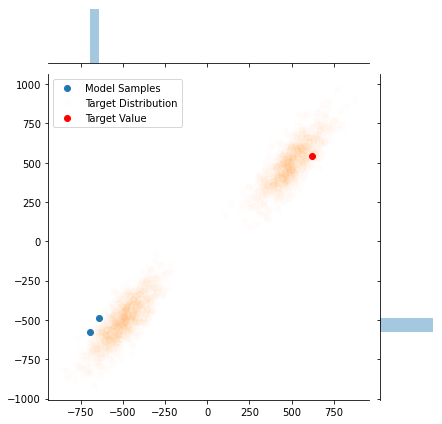

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
make_distplot(sample,true_value ,y_test)

In [ ]:
class LitAutoEncoder(pl.LightningModule):
    def training_step(self, batch, batch_idx, optimizer_idx):
        # access your optimizers with use_pl_optimizer=False. Default is True
        (opt_a, opt_b) = self.optimizers(use_pl_optimizer=True)

        loss_a = ...
        self.manual_backward(loss_a, opt_a)
        opt_a.step()
        opt_a.zero_grad()

        loss_b = ...
        self.manual_backward(loss_b, opt_b, retain_graph=True)
        self.manual_backward(loss_b, opt_b)
        opt_b.step()
        opt_b.zero_grad()